In [2]:
import pandas as pd
import requests
import time
import datetime
import json
import ast
import subprocess


def spark_get_app_jobs(app_id):
    spark_hists_host='neu-3-1'
    spark_hists_port=18080
    URL = "http://%s:%d/api/v1/applications/%s/jobs"%(spark_hists_host,spark_hists_port,
                                                      app_id)
    return requests.get(url = URL).json()
    
def get_spark_job(app_id, jobid):
    spark_hists_host='neu-3-1'
    spark_hists_port=18080
    URL = "http://%s:%d/api/v1/applications/%s/jobs/%d"%(spark_hists_host,spark_hists_port,
                                                      app_id, jobid)
    return requests.get(url = URL).json()

def spark_get_app_stages(app_id):
    spark_hists_host='neu-3-1'
    spark_hists_port=18080
    URL = "http://%s:%d/api/v1/applications/%s/stages"%(spark_hists_host, spark_hists_port, 
                                                      app_id)
    return requests.get(url = URL).json()

def spark_get_app_stage(app_id, stage_id):
    spark_hists_host='neu-3-1'
    spark_hists_port=18080
    URL = "http://%s:%d/api/v1/applications/%s/stages/%d"%(spark_hists_host, spark_hists_port, 
                                                      app_id, stage_id)
    return requests.get(url = URL).json()


def get_spark_apps():
    spark_hists_host='neu-3-1'
    spark_hists_port=18080
    URL = "http://%s:%d/api/v1/applications"%(spark_hists_host,spark_hists_port)
    return requests.get(url = URL).json()

def get_dag_from_log(app_id):
    cat = subprocess.Popen(["hadoop", "fs", "-cat", '/local0/spark-logs/%s'%(app_id)], 
                           stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = cat.communicate()
    stage_inputs = {}
    job_dag_str = ''
    for l in stdout.decode().split('\n'):
        l = l.replace('\n', '')
        if l.startswith('{"Event":"SparkListenerJobStart"'):
            job = json.loads(l)
            for stage in job['Stage Infos']:
                for rdd in stage["RDD Info"]:
                    if not rdd["Parent IDs"]:
                        stage_inputs[stage['Stage ID']] = rdd['Name'].split('.')[0].split('/')[-1]                
                if len(stage['Parent IDs']) == 0:
                    job_dag_str += 'j:%s,e:->%s\n'%(job['Job ID'],stage['Stage ID'])
                    continue
                for pid in stage['Parent IDs']:
                    job_dag_str += 'j:%s,e:%s->%s\n'%(job['Job ID'],pid,stage['Stage ID'])                
    print('Application %s has been processed'%(app_id))
    return job_dag_str, stage_inputs

app_name_to_id = {}
appid_to_stagestables = {}
for app in get_spark_apps():
    if not app['name'].startswith('framework:spark'):
        continue
    app_dag_str, stages_tables = get_dag_from_log(app['id']) 
    app_name_to_id[app['name']] = {
        'app_name' : app['name'],
        'app_id' : app['id'],
        'app_start_time': app['attempts'][0]['startTimeEpoch'],
        'app_completion_time': app['attempts'][0]['endTimeEpoch'],
        'app_dag': app_dag_str}
    appid_to_stagestables[app['id']] = stages_tables
    for i in app['name'].split('-'):
        app_name_to_id[app['name']][i.split(':')[0]] = i.split(':')[1]

KeyboardInterrupt: 

In [27]:
df = pd.read_csv('/local0/Kariz/expriments/simulator/multidag/config/spark_multidag_selected_queries.csv')
df.columns

Index(['app_completion_time', 'app_dag', 'app_id', 'app_name',
       'app_start_time', 'bw', 'ds', 'framework', 'job_completion_time',
       'job_id', 'job_stage_ids', 'job_submission_time', 'name', 'numTasks',
       'outputBytes', 'random', 'stage_completion_time', 'stage_id',
       'stage_input_bytes', 'stage_queue_time', 'stage_rdds', 'stage_run_time',
       'stage_shuffle_read_bytes', 'stage_shuffle_write_bytes',
       'stage_start_time', 'stage_submission_time', 'stride', 'app_runtime',
       'feature', 'tables', 'prefetched_blocks', 'prefetched_bytes', 'bw_i',
       'sequentials'],
      dtype='object')

In [28]:
fpath='/local0/Kariz/expriments/runtime_prediction/tpch/runtime.pred.spark.stats.csv'
kariz_apps = pd.read_csv(fpath)
kariz_apps.head(5)

,app_name
0,framework:spark-name:tpch17-bw:40Gbps-ds:-stride:90-random:hszhwpis
1,framework:spark-name:tpch9-bw:5Gbps-ds:20G-stride:50-random:munbjefq
2,framework:spark-name:tpch3-bw:5Gbps-ds:20G-stride:100-random:xqrhrjjz
3,framework:spark-name:tpch22-bw:10Gbps-ds:20G-stride:90-random:sedbveld
4,framework:spark-name:tpch13-bw:40Gbps-ds:20G-stride:80-random:ufhowguh


In [5]:
def get_spark_app_history(row, app_stats):
    if row['app_name'] not in app_name_to_id:
        return 
    
    app_meta = app_name_to_id[row['app_name']]
    app_id = app_name_to_id[row['app_name']]['app_id']
    
    print('Application', app_id, 'with name', row['app_name'], 'to be processed')
    
    # jobs within this application
    jobs = spark_get_app_jobs(app_id)
    for job in jobs:
        job_start_time = time.mktime(datetime.datetime.strptime(job['submissionTime'],
                                                     "%Y-%m-%dT%H:%M:%S.%fGMT").timetuple())
        job_completion_time = time.mktime(datetime.datetime.strptime(job['completionTime'],
                                                     "%Y-%m-%dT%H:%M:%S.%fGMT").timetuple())

        stages = job['stageIds']
        for sid in stages:
            stage = spark_get_app_stage(app_id, sid)[0]
            
            if stage['status'] == 'SKIPPED':
                continue
            
            stage_submit_time = time.mktime(datetime.datetime.strptime(stage['submissionTime'],
                                                         "%Y-%m-%dT%H:%M:%S.%fGMT").timetuple())
            stage_start_time = time.mktime(datetime.datetime.strptime(stage['firstTaskLaunchedTime'],
                                                         "%Y-%m-%dT%H:%M:%S.%fGMT").timetuple())
            stage_completion_time = time.mktime(datetime.datetime.strptime(stage['completionTime'],
                                                         "%Y-%m-%dT%H:%M:%S.%fGMT").timetuple())
            stage_queue_time = stage_start_time - stage_submit_time
            stage_run_time = stage_completion_time - stage_start_time

            stage_stats = {
                      'job_id': job['jobId'], 
                      'job_submission_time': job_start_time,
                      'job_completion_time': job_completion_time,
                      'job_stage_ids': job['stageIds'],
                      'stage_id': stage['stageId'], 'numTasks': stage['numTasks'], 
                      'stage_submission_time': stage_submit_time, 
                      'stage_start_time': stage_start_time, 
                      'stage_completion_time': stage_completion_time,
                      'stage_queue_time': stage_queue_time,
                      'stage_run_time': stage_run_time,
                      'stage_input_bytes': stage['inputBytes'], 
                      'outputBytes': stage['outputBytes'], 
                      'stage_shuffle_read_bytes': stage['shuffleReadBytes'], 
                      'stage_shuffle_write_bytes': stage['shuffleWriteBytes'],
                      'stage_rdds': stage['rddIds']}
            stage_stats.update(app_meta)
            app_stats.append(stage_stats)

application_stats = []
kariz_apps.apply(get_spark_app_history, axis=1, app_stats=application_stats)
df = pd.DataFrame(application_stats)


In [29]:
print(df.columns)

df['app_runtime'] = df['app_completion_time'] - df['app_start_time']
df[['app_runtime', 'bw', 'ds', 'stride']].sort_values(by='app_runtime',ascending=False).head(5)

Index(['app_completion_time', 'app_dag', 'app_id', 'app_name',
       'app_start_time', 'bw', 'ds', 'framework', 'job_completion_time',
       'job_id', 'job_stage_ids', 'job_submission_time', 'name', 'numTasks',
       'outputBytes', 'random', 'stage_completion_time', 'stage_id',
       'stage_input_bytes', 'stage_queue_time', 'stage_rdds', 'stage_run_time',
       'stage_shuffle_read_bytes', 'stage_shuffle_write_bytes',
       'stage_start_time', 'stage_submission_time', 'stride', 'app_runtime',
       'feature', 'tables', 'prefetched_blocks', 'prefetched_bytes', 'bw_i',
       'sequentials'],
      dtype='object')


,app_runtime,bw,ds,stride
817,433836,1Gbps,64G,25
824,433836,1Gbps,64G,25
823,433836,1Gbps,64G,25
822,433836,1Gbps,64G,25
821,433836,1Gbps,64G,25


In [30]:
ppath='/local0/Kariz/expriments/runtime_prediction/tpch/runtime.pred.spark.prefetch.csv'
dp = pd.read_csv(ppath)
dp.head(5)

,app_name,path,prefetched,requested,stride
0,framework:spark-name:tpch6-bw:20Gbps-ds:-stride:10-random:yryilqex,pig-tpch/20G/customer,11,11,10
1,framework:spark-name:tpch6-bw:20Gbps-ds:-stride:10-random:yryilqex,pig-tpch/20G/lineitem,371,371,10
2,framework:spark-name:tpch6-bw:20Gbps-ds:-stride:10-random:yryilqex,pig-tpch/20G/nation,0,0,10
3,framework:spark-name:tpch6-bw:20Gbps-ds:-stride:10-random:yryilqex,pig-tpch/20G/orders,83,83,10
4,framework:spark-name:tpch6-bw:20Gbps-ds:-stride:10-random:yryilqex,pig-tpch/20G/part,11,11,10


In [31]:
dm = df.groupby('app_id')['name', 'app_dag'].agg('max').reset_index()
pd.set_option("display.max_colwidth",800)

string_to_query=[]
n_uniques = 0
for i in range(1,23):
    for j, dag_str in enumerate(dm[dm['name']=='tpch%d'%(i)].groupby('app_dag').agg('max').reset_index()['app_dag'].values):
        n_uniques += 1
        string_to_query.append({'query': i, 'dag': dag_str, 'index': j, 'id': n_uniques})

sq_df = pd.DataFrame(string_to_query)

sq_df

<ipython-input-31-b063246f6f56>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dm = df.groupby('app_id')['name', 'app_dag'].agg('max').reset_index()


,query,dag,index,id
0,1,"j:0,e:->0\nj:0,e:0->1\nj:1,e:->2\nj:1,e:2->3\nj:1,e:3->4\n",0,1
1,2,"j:0,e:->0\nj:0,e:6->15\nj:0,e:7->15\nj:0,e:->9\nj:0,e:->1\nj:0,e:15->16\nj:0,e:14->16\nj:0,e:0->2\nj:0,e:1->2\nj:0,e:16->17\nj:0,e:->3\nj:0,e:0->10\nj:0,e:8->10\nj:0,e:2->4\nj:0,e:3->4\nj:0,e:9->11\nj:0,e:10->11\nj:0,e:->12\nj:0,e:5->13\nj:0,e:11->13\nj:0,e:->5\nj:0,e:5->6\nj:0,e:4->6\nj:0,e:->7\nj:0,e:12->14\nj:0,e:13->14\nj:0,e:->8\n",0,2
2,3,"j:0,e:->0\nj:0,e:->1\nj:0,e:4->5\nj:0,e:->2\nj:0,e:0->3\nj:0,e:1->3\nj:0,e:2->4\nj:0,e:3->4\n",0,3
3,4,"j:0,e:->0\nj:0,e:->1\nj:0,e:0->2\nj:0,e:1->2\nj:0,e:2->3\nj:1,e:->5\nj:1,e:5->6\nj:1,e:4->6\nj:1,e:6->7\nj:1,e:->4\nj:1,e:7->8\n",0,4
4,5,"j:0,e:->0\nj:0,e:6->9\nj:0,e:7->9\nj:0,e:->1\nj:0,e:->5\nj:0,e:0->2\nj:0,e:1->2\nj:0,e:5->6\nj:0,e:4->6\nj:0,e:->3\nj:0,e:9->10\nj:0,e:8->10\nj:0,e:->7\nj:0,e:2->4\nj:0,e:3->4\nj:0,e:10->11\nj:0,e:->8\nj:1,e:->15\nj:1,e:->12\nj:1,e:->19\nj:1,e:15->16\nj:1,e:14->16\nj:1,e:->13\nj:1,e:->20\nj:1,e:->17\nj:1,e:23->24\nj:1,e:19->21\nj:1,e:18->21\nj:1,e:16->18\nj:1,e:17->18\nj:1,e:20->22\nj:1,e:21->22\nj:1,e:12->14\nj:1,e:13->14\nj:1,e:22->23\n",0,5
5,5,"j:0,e:->0\nj:0,e:6->9\nj:0,e:7->9\nj:0,e:->1\nj:0,e:2->5\nj:0,e:3->5\nj:0,e:->2\nj:0,e:5->6\nj:0,e:4->6\nj:0,e:0->3\nj:0,e:1->3\nj:0,e:9->10\nj:0,e:8->10\nj:0,e:->7\nj:0,e:->4\nj:0,e:10->11\nj:0,e:->8\nj:1,e:12->15\nj:1,e:13->15\nj:1,e:->12\nj:1,e:->19\nj:1,e:->16\nj:1,e:->13\nj:1,e:->20\nj:1,e:15->17\nj:1,e:14->17\nj:1,e:23->24\nj:1,e:19->21\nj:1,e:18->21\nj:1,e:16->18\nj:1,e:17->18\nj:1,e:20->22\nj:1,e:21->22\nj:1,e:->14\nj:1,e:22->23\n",1,6
6,6,"j:0,e:->0\nj:0,e:0->1\n",0,7
7,7,"j:0,e:->0\nj:0,e:7->9\nj:0,e:8->9\nj:0,e:->1\nj:0,e:1->5\nj:0,e:4->5\nj:0,e:->2\nj:0,e:->6\nj:0,e:0->3\nj:0,e:1->3\nj:0,e:9->10\nj:0,e:5->7\nj:0,e:6->7\nj:0,e:->4\nj:0,e:2->8\nj:0,e:3->8\nj:1,e:->15\nj:1,e:->12\nj:1,e:13->19\nj:1,e:14->19\nj:1,e:15->16\nj:1,e:12->16\nj:1,e:->13\nj:1,e:19->20\nj:1,e:18->20\nj:1,e:->17\nj:1,e:20->21\nj:1,e:16->18\nj:1,e:17->18\nj:1,e:21->22\nj:1,e:12->14\nj:1,e:11->14\nj:1,e:->11\n",0,8
8,8,"j:0,e:->0\nj:0,e:14->15\nj:0,e:->9\nj:0,e:->1\nj:0,e:->2\nj:0,e:0->3\nj:0,e:1->3\nj:0,e:9->10\nj:0,e:8->10\nj:0,e:2->4\nj:0,e:3->4\nj:0,e:6->11\nj:0,e:7->11\nj:0,e:10->12\nj:0,e:11->12\nj:0,e:5->13\nj:0,e:4->13\nj:0,e:->5\nj:0,e:->6\nj:0,e:->7\nj:0,e:12->14\nj:0,e:13->14\nj:0,e:->8\nj:1,e:28->30\nj:1,e:29->30\nj:1,e:->16\nj:1,e:30->31\nj:1,e:->17\nj:1,e:31->32\nj:1,e:->24\nj:1,e:->18\nj:1,e:->25\nj:1,e:24->26\nj:1,e:25->26\nj:1,e:22->27\nj:1,e:23->27\nj:1,e:16->19\nj:1,e:17->19\nj:1,e:19->20\nj:1,e:18->20\nj:1,e:->21\nj:1,e:27->28\nj:1,e:26->28\nj:1,e:->22\nj:1,e:20->29\nj:1,e:21->29\nj:1,e:->23\n",0,9
9,9,"j:0,e:->0\nj:0,e:->9\nj:0,e:->1\nj:0,e:0->5\nj:0,e:1->5\nj:0,e:->2\nj:0,e:5->6\nj:0,e:4->6\nj:0,e:->3\nj:0,e:9->10\nj:0,e:8->10\nj:0,e:->7\nj:0,e:2->4\nj:0,e:3->4\nj:0,e:10->11\nj:0,e:6->8\nj:0,e:7->8\nj:1,e:->15\nj:1,e:->12\nj:1,e:->19\nj:1,e:15->16\nj:1,e:14->16\nj:1,e:->13\nj:1,e:19->20\nj:1,e:18->20\nj:1,e:12->17\nj:1,e:13->17\nj:1,e:23->24\nj:1,e:->21\nj:1,e:16->18\nj:1,e:17->18\nj:1,e:20->22\nj:1,e:21->22\nj:1,e:->14\nj:1,e:22->23\n",0,10


In [32]:
# read graphs and build graph pool 
import graph_tool.all as gt

sptpath = '/local0/Kariz/expriments/simulator/multidag/spark.tpch.template'

def build_graph_from_string(dag_str):
    meta = dag_str.split('\n')[0]
    g_name, g_index = meta.split('Q')[1].split(',')
    g_elements = dag_str.split('\n')[1:]
    g_queuetime = 0
    print(meta, g_index, g_name)
    if len(sq_df[(sq_df['query']==int(g_name)) & (sq_df['index']==int(g_index))]['id'].values) == 0:
        return -1
    g_id = sq_df[(sq_df['query']==int(g_name)) & (sq_df['index']==int(g_index))]['id'].values[0]
    print('query', g_name, 'index', g_index, 'id', g_id)
    
    g = gt.Graph(directed=True)
    g.gp['name'] = g.new_graph_property("string", 'Q%s,%s'%(g_name,g_index))
    g.gp['id'] = g.new_graph_property("int", str(g_id))
    g.gp['queue_time'] = g.new_graph_property("int", g_queuetime)
    g.gp['cur_stage'] = g.new_graph_property("int", -1)
    status = g.new_vertex_property("int")
    inputs = g.new_vertex_property("string")
    color = g.new_vertex_property("string")
    ops = g.new_vertex_property("string")
    vids = g.new_vertex_property("string")
    sv_gv = {}
    # build vertices
    for el in g_elements[:-1]:
        if el.startswith('v'):
           # print(el)
            vid, operation, inputs_str = el.split(',')[1:]
            v = g.add_vertex()
            vids[v] = vid
            sv_gv[vid] = v
            inputs[v] = inputs_str #build_input_format(inputs_str)
            ops[v] = operation if operation else 'skipped'
            color[v] = '#fb8072' if len(inputs[v]) > 0 else '#bdbdbd' if ops[v] == 'skipped' else '#80b1d3'
            #if g_name == '11' and g_index=='1':
            #    print(v, vids[v], inputs[v])
        
    # build edges
    for el in g_elements[:-1]:
        if el.startswith('e'):
            #if g_name == '11' and g_index=='1' :
            #    print(el)
            v_src, v_dest = el.split(',')[1:]
            e = g.add_edge(sv_gv[v_src], sv_gv[v_dest])

    g.vp['vids'] = vids
    g.vp['color'] = color
    g.vp['tables'] = inputs
    g.vp['status'] = status
    g.vp['feature'] = ops
    if g_name == '23' and g_index=='0':
        gt.graph_draw(g, vertex_text=g.vp.vids, vertex_color=g.vp.color, 
                  vertex_fill_color=g.vp.color, size=(700, 700))
    return g

graphs_pool = {}
with open(sptpath, 'r') as fd:
    dag_strs = fd.read().split('#')[1:]
    for index, dag_str in enumerate(dag_strs):
        g = build_graph_from_string(dag_str)
        if isinstance(g, int):
            continue
        graphs_pool[g.gp.id] = g
        if index ==43:
            break
            
print('Total number of graphs in the graph pool', len(graphs_pool))

t      TPCH_Q1,0 0 1
query 1 index 0 id 1
t      TPCH_Q2,0 0 2
query 2 index 0 id 2
t      TPCH_Q2,1 1 2
t      TPCH_Q2,2 2 2
t      TPCH_Q2,3 3 2
t      TPCH_Q3,0 0 3
query 3 index 0 id 3
t      TPCH_Q4,0 0 4
query 4 index 0 id 4
t      TPCH_Q5,0 0 5
query 5 index 0 id 5
t      TPCH_Q5,1 1 5
query 5 index 1 id 6
t      TPCH_Q5,2 2 5
t      TPCH_Q6,0 0 6
query 6 index 0 id 7
t	TPCH_Q7,0 0 7
query 7 index 0 id 8
t      TPCH_Q7,1 1 7
t      TPCH_Q7,2 2 7
t      TPCH_Q8,0 0 8
query 8 index 0 id 9
t	TPCH_Q9,0 0 9
query 9 index 0 id 10
t      TPCH_Q9,1 1 9
t	TPCH_Q10,0 0 10
query 10 index 0 id 11
t      TPCH_Q10,1 1 10
query 10 index 1 id 12
t      TPCH_Q10,2 2 10
t	TPCH_Q12,0 0 12
query 12 index 0 id 16
t	TPCH_Q13,0 0 13
query 13 index 0 id 17
t      TPCH_Q14,0 0 14
query 14 index 0 id 18
t      TPCH_Q15,0 0 15
query 15 index 0 id 19
t	TPCH_Q16,0 0 16
query 16 index 0 id 20
t      TPCH_Q16,1 1 16
t	TPCH_Q17,0 0 17
query 17 index 0 id 21
t      TPCH_Q17,1 1 17
t      TPCH_Q17,2 2 17
t	TPCH_

In [15]:
cache_block_size = 4*1024*1024

def bandwidth_regularization(row):
    if 'Gbps' in row['bw']:
        row ['bw_i'] = float(row['bw'].replace(r'Gbps', ''))
    elif 'Mbps' in row['bw']:
        row['bw_i'] = int(row['bw'].replace(r'Mbps', ''))/1000
    else:
        raise NameError('The bandwidth string is not parsable')
    return row

def assign_prefetched_blocks(row):
    row['prefetched_blocks'] = 0
    if row['tables'] and int(row['stride'])>0:
        table = 'pig-tpch/%s/%s'%(row['ds'], row['tables'])
        row['prefetched_blocks'] = dp[(dp['app_name'] == row['app_name']) & (dp['path'] == table)]['prefetched'].values[0]
    row['prefetched_bytes'] = row['prefetched_blocks']*cache_block_size
    return row

def annotate_dag(row):
    query = row['name'].replace('tpch', '')
    stage_id = row['stage_id']
    query_dag = row['app_dag']
    g_id = sq_df[(sq_df['query']==int(query)) & (sq_df['dag'] == query_dag)]['id'].values[0]
    g = graphs_pool[g_id]
    v = gt.find_vertex(g, g.vp.vids, stage_id)[0]
    row['feature'] = g.vp.feature[v]
    
    if stage_id in appid_to_stagestables[row['app_id']]:
        row['tables'] = appid_to_stagestables[row['app_id']][stage_id].replace(' ', '')
        g.vp.tables[v]= appid_to_stagestables[row['app_id']][stage_id].replace(' ', '')
    else:
        g.vp.tables[v] = ''
        row['tables'] = ''
        
    row = assign_prefetched_blocks(row)
    row = bandwidth_regularization(row)
    return row
    
df =  df.apply(annotate_dag, axis=1)
print(df.columns)



KeyError: 'app-20200905104849-0012'

In [33]:
df[['stage_input_bytes', 'prefetched_bytes', 'stage_shuffle_read_bytes','stride']].head(5)

,stage_input_bytes,prefetched_bytes,stage_shuffle_read_bytes,stride
0,0,0,443676,80
1,0,0,2827,80
2,3487488366,2789212160,0,80
3,487806602,335544320,0,80
4,0,0,327567309,80


In [34]:
import numpy as np

def get_aggregate(row):
    pred_row = {}
    logd = (row['stage_input_bytes'] + row['stage_shuffle_read_bytes'])/row['numTasks']    
    if not logd:
        pred_row['aggregate'] = 0 
    else:
        pred_row['aggregate'] = np.log(logd)
    return pred_row['aggregate']

def get_sort(row):
    pred_row = {}
    logd = (row['stage_input_bytes'] + row['stage_shuffle_read_bytes'])/row['numTasks']    
    if not logd:
        pred_row['sort'] = 0
    else:
        pred_row['sort'] = logd*np.log(logd)
    return pred_row['sort']



bw_cache = 5*(10**9)

df2 = pd.DataFrame()
#df2 = df.apply(build_prediction_df, axis=1)
df2['prefetched_bytes'] = df['prefetched_bytes']
df2['feature'] = df['feature']
df2['input_sz'] = df['stage_input_bytes']
df2['cache_read'] =  df['prefetched_bytes']/bw_cache
df2['remote_read'] = np.abs(8*(df['stage_input_bytes'] - df['prefetched_bytes'])/(df['bw_i']*(10**9)))
df2['sequential'] = (df['stage_input_bytes'] + df['stage_shuffle_read_bytes'])/df['numTasks']
df2['aggregate'] = np.log(df['numTasks'])#df.apply(get_aggregate, axis=1) #np.log((df['stage_input_bytes'] + df['stage_shuffle_read_bytes'])/df['numTasks'])
df2['sort'] = df.apply(get_sort, axis=1) #((df['stage_input_bytes'] + df['stage_shuffle_read_bytes'])/df['numTasks'])*np.log((df['stage_input_bytes'] + df['stage_shuffle_read_bytes'])/df['numTasks'])
df2['shuffle'] = (df['numTasks'])#*dt['total_bytes']
df2['runtime'] = df['stage_run_time']
df2['app_name'] = df['app_name']
df2['stage_id'] = df['stage_id']
df2['tables'] = df['tables']

HASHAGGREGATE , n_training 124 n_test 32 
               Coefficient
remote_read  0.000000e+00
cache_read   0.000000e+00
sequential   4.304024e-07
shuffle      0.000000e+00
aggregate    8.693996e-02 
intercept 0.49351345586683726


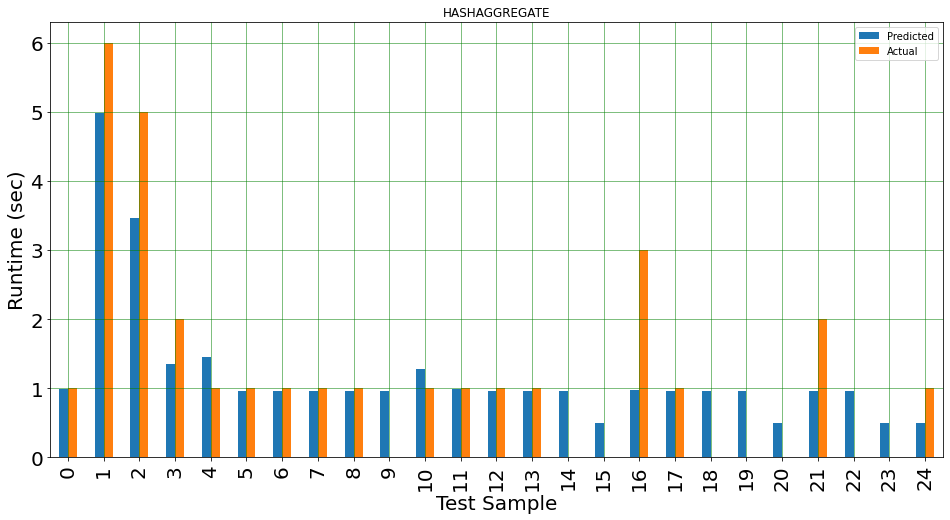

Median Absolute Error: 0.4985911280425078
Max RRS Error: 2.0197230305018117
Mean Absolute Error: 0.5849673764784462
Mean Squared Error: 0.5935488516231296
Root Mean Squared Error: 0.7704212170125702
Mean stage runtime: 1.1875
******************************************************* 



HASHAGGREGATE:BROADCASTNESTEDJOINLOOP , n_training 4 n_test 2 
              Coefficient
remote_read          0.0
cache_read           0.0
sequential           0.0
shuffle              0.0
aggregate            0.0 
intercept 0.75


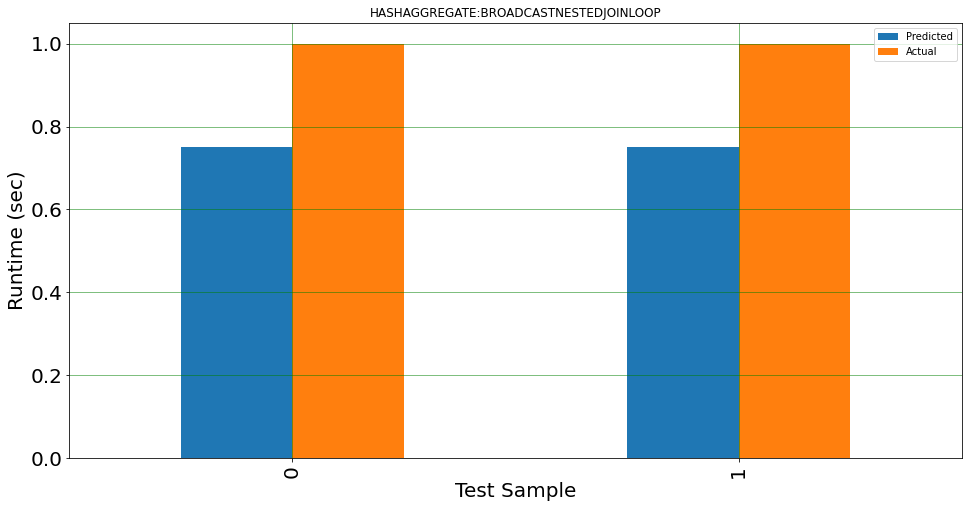

Median Absolute Error: 0.25
Max RRS Error: 0.25
Mean Absolute Error: 0.25
Mean Squared Error: 0.0625
Root Mean Squared Error: 0.25
Mean stage runtime: 1.0
******************************************************* 



HASHAGGREGATE:FILTER , n_training 15 n_test 4 
               Coefficient
remote_read  0.000000e+00
cache_read   0.000000e+00
sequential   2.180218e-07
shuffle      9.485725e-06
aggregate    1.147411e-01 
intercept 0.7992566777817252


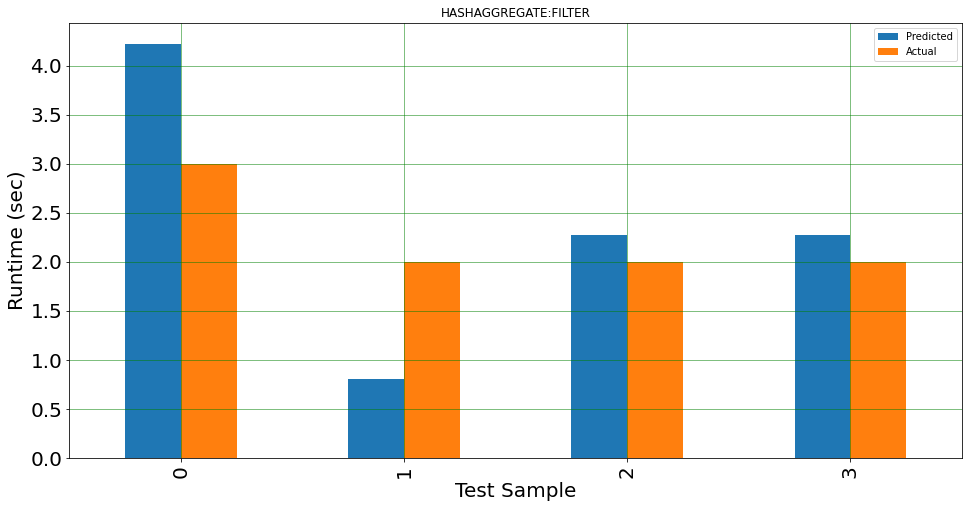

Median Absolute Error: 0.7355379748514262
Max RRS Error: 1.223478477705548
Mean Absolute Error: 0.7413723899994431
Mean Squared Error: 0.7710123146132348
Root Mean Squared Error: 0.878073069062726
Mean stage runtime: 2.25
******************************************************* 



SCAN , n_training 152 n_test 39 
               Coefficient
remote_read  1.288755e+00
cache_read   3.129729e+00
sequential   5.154002e-09
shuffle      0.000000e+00
aggregate    8.860116e-01 
intercept 3.7234988653751646


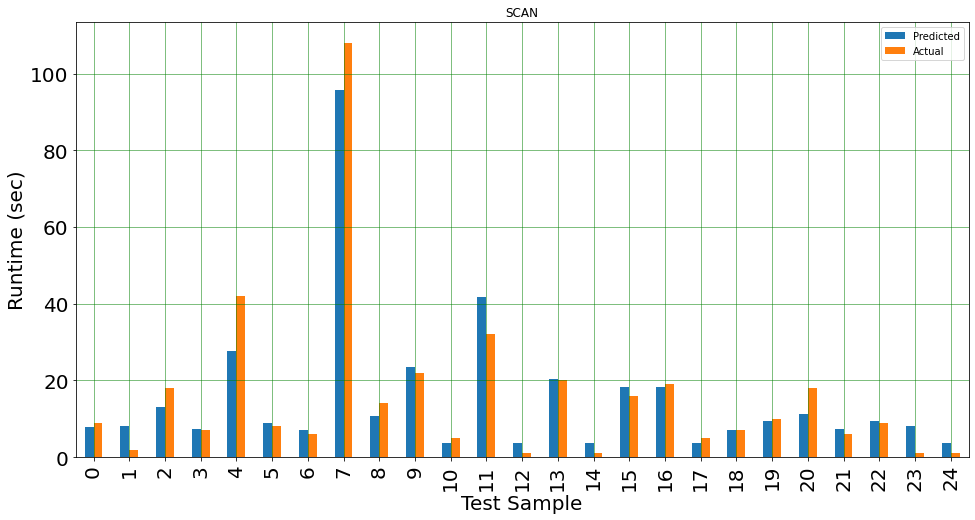

Median Absolute Error: 2.634787768198205
Max RRS Error: 15.27136375363996
Mean Absolute Error: 3.923060528602005
Mean Squared Error: 32.67117608033655
Root Mean Squared Error: 5.7158705443997375
Mean stage runtime: 15.051282051282051
******************************************************* 



SCAN:FILTER , n_training 102 n_test 26 
              Coefficient
remote_read     1.306754
cache_read      1.978764
sequential      0.000000
shuffle         0.000000
aggregate       1.233903 
intercept 4.333881034761996


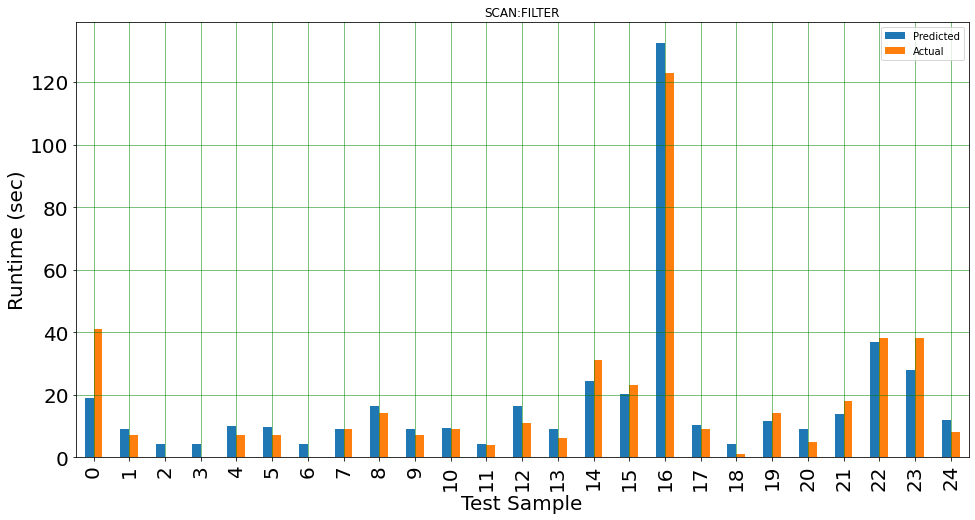

Median Absolute Error: 3.223615342574492
Max RRS Error: 21.964459644042996
Mean Absolute Error: 4.640009791524746
Mean Squared Error: 45.07796609473988
Root Mean Squared Error: 6.714012667156644
Mean stage runtime: 18.346153846153847
******************************************************* 



SCAN:FILTER:HASHAGGREGATE , n_training 31 n_test 8 
               Coefficient
remote_read  1.015868e+00
cache_read   8.038495e-01
sequential   1.380963e-08
shuffle      0.000000e+00
aggregate    0.000000e+00 
intercept 8.947334993143052


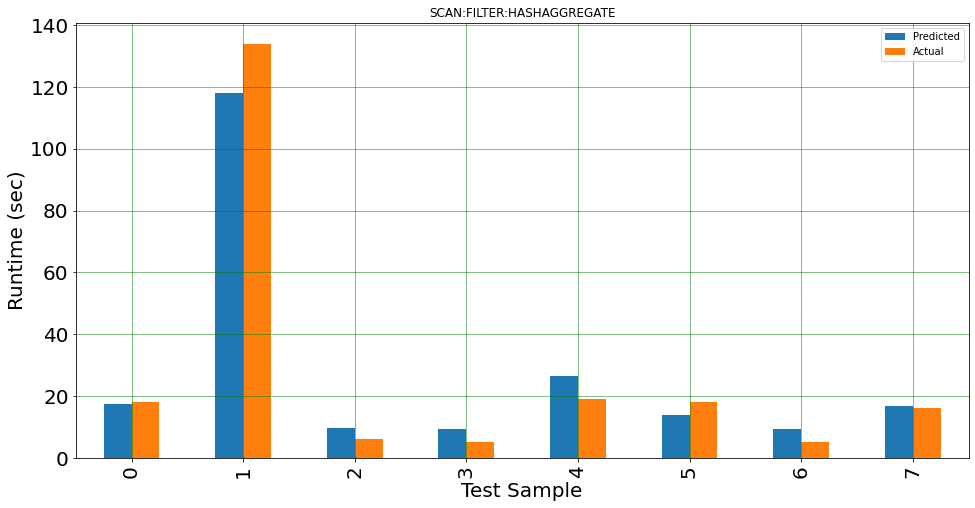

Median Absolute Error: 4.098910893063311
Max RRS Error: 15.917049159083405
Mean Absolute Error: 5.131652859516181
Mean Squared Error: 47.06382692578405
Root Mean Squared Error: 6.860308078051892
Mean stage runtime: 27.625
******************************************************* 



SCAN:HASHAGGREGATE , n_training 12 n_test 4 
               Coefficient
remote_read  1.246049e+00
cache_read   0.000000e+00
sequential   8.595943e-08
shuffle      0.000000e+00
aggregate    0.000000e+00 
intercept -3.131764326812558


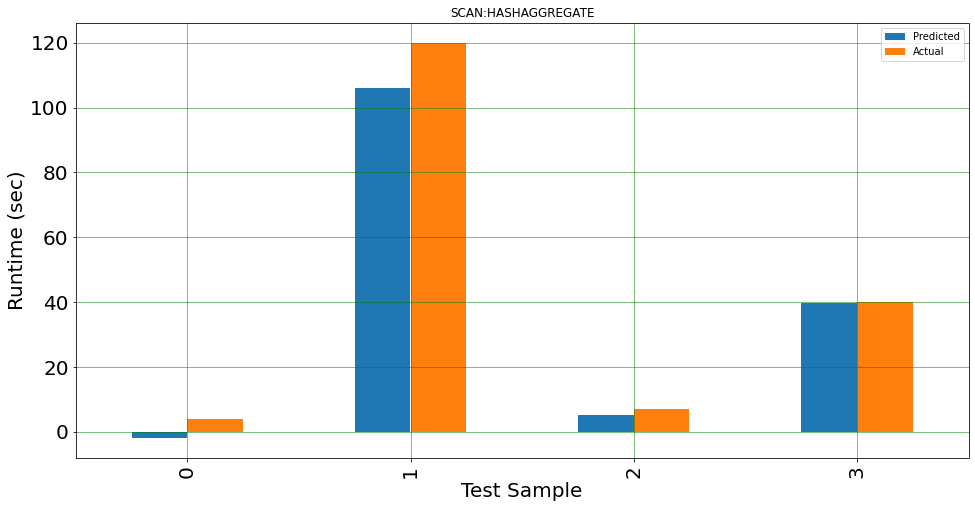

Median Absolute Error: 3.9733508613775084
Max RRS Error: 13.999912008191117
Mean Absolute Error: 5.524825398548394
Mean Squared Error: 58.96802407627804
Root Mean Squared Error: 7.67906401042979
Mean stage runtime: 42.75
******************************************************* 



SORT , n_training 60 n_test 15 
               Coefficient
remote_read  0.000000e+00
cache_read   0.000000e+00
sequential   9.697446e-08
shuffle      1.473416e-03
aggregate    9.297028e-02 
intercept 0.5472051330645227


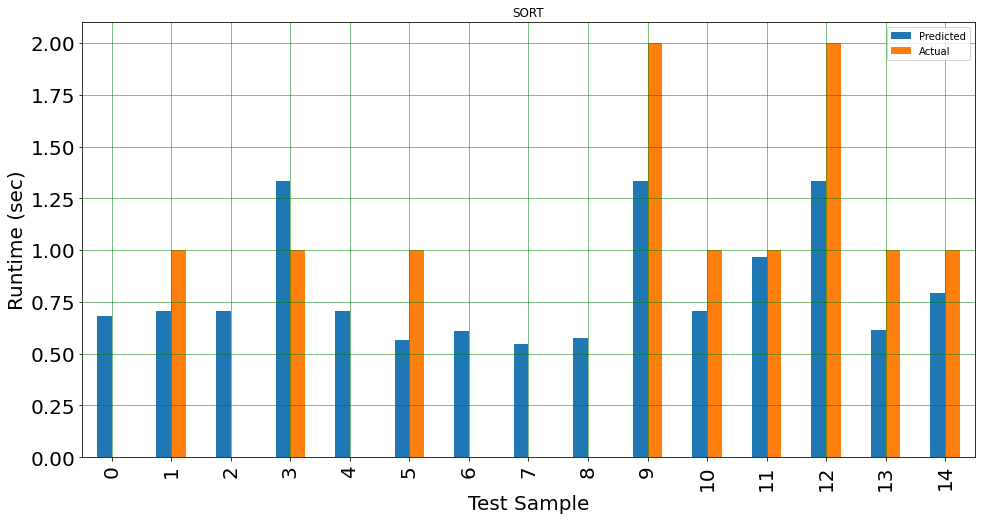

Median Absolute Error: 0.5486785486906489
Max RRS Error: 0.7042093793678925
Mean Absolute Error: 0.4758441944535327
Mean Squared Error: 0.26733908962592373
Root Mean Squared Error: 0.5170484403089557
Mean stage runtime: 0.7333333333333333
******************************************************* 



SORT:SORTMERGEJOIN , n_training 136 n_test 35 
               Coefficient
remote_read  0.000000e+00
cache_read   0.000000e+00
sequential   1.462087e-07
shuffle      0.000000e+00
aggregate    0.000000e+00 
intercept 2.7727325758900885


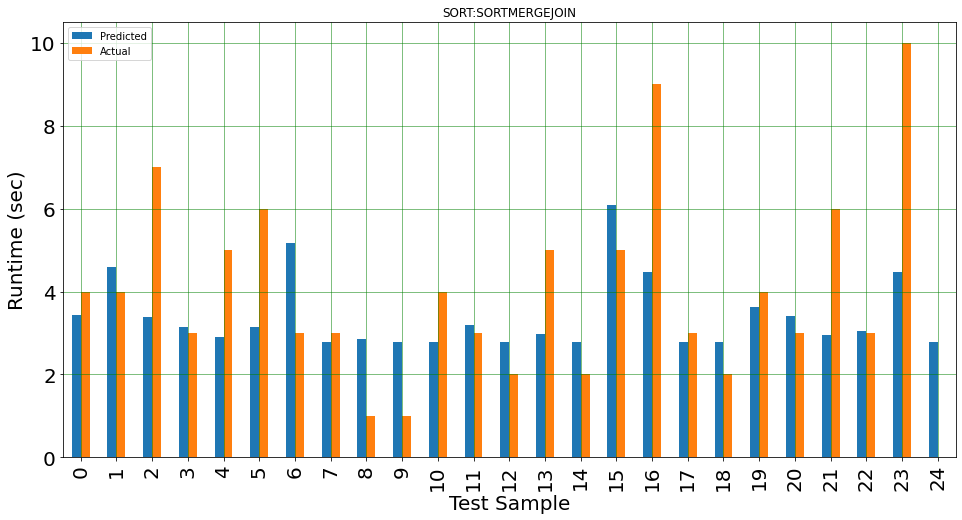

Median Absolute Error: 1.2272670330016502
Max RRS Error: 5.534400311331051
Mean Absolute Error: 1.6436914967090264
Mean Squared Error: 4.548546070621774
Root Mean Squared Error: 2.1327320672371797
Mean stage runtime: 3.8285714285714287
******************************************************* 



SORT:SORTMERGEJOIN:HASHAGGREGATE , n_training 78 n_test 20 
               Coefficient
remote_read  0.000000e+00
cache_read   0.000000e+00
sequential   1.566707e-07
shuffle      6.155249e-06
aggregate    5.869538e-01 
intercept 0.1762506828282806


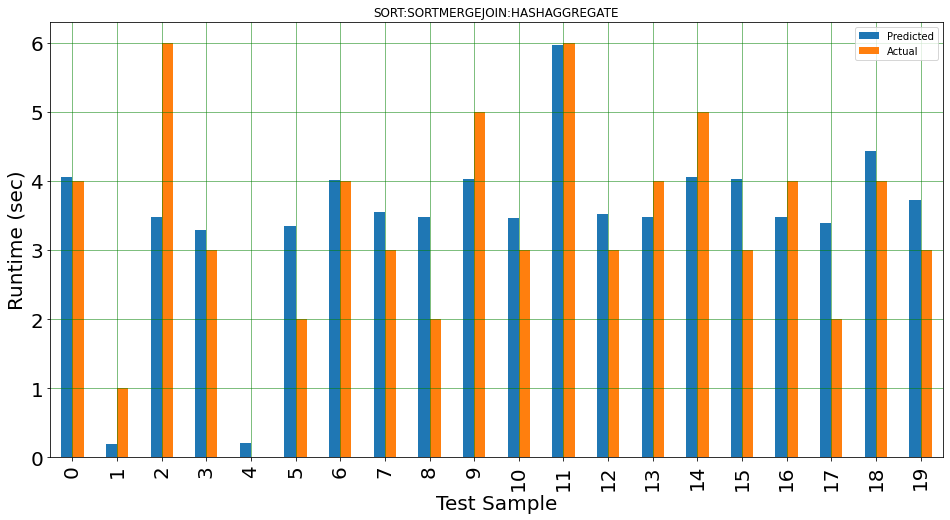

Median Absolute Error: 0.5395750764447222
Max RRS Error: 2.5145814207843515
Mean Absolute Error: 0.7414244619593252
Mean Squared Error: 0.8993845874348633
Root Mean Squared Error: 0.9483588916833454
Mean stage runtime: 3.35
******************************************************* 



SORT:SORTMERGEJOIN:HASHAGGREGATE:FILTER , n_training 4 n_test 2 
               Coefficient
remote_read  0.000000e+00
cache_read   0.000000e+00
sequential   9.462555e-07
shuffle      0.000000e+00
aggregate    0.000000e+00 
intercept 3.8146967046173663


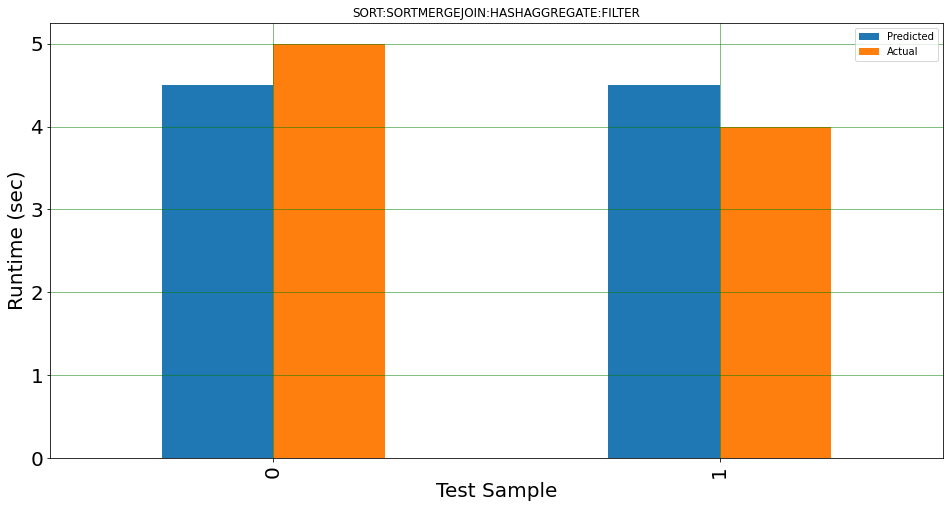

Median Absolute Error: 0.5
Max RRS Error: 0.5000000003785026
Mean Absolute Error: 0.5
Mean Squared Error: 0.25
Root Mean Squared Error: 0.5
Mean stage runtime: 4.5
******************************************************* 



SORT:SORTMERGEJOIN:HASHAGGREGATE:FILTER:BROADCASTHASHJOIN , n_training 6 n_test 2 
              Coefficient
remote_read     0.000000
cache_read      0.000000
sequential      0.000001
shuffle         0.000000
aggregate       0.000000 
intercept 1.2336391215336449


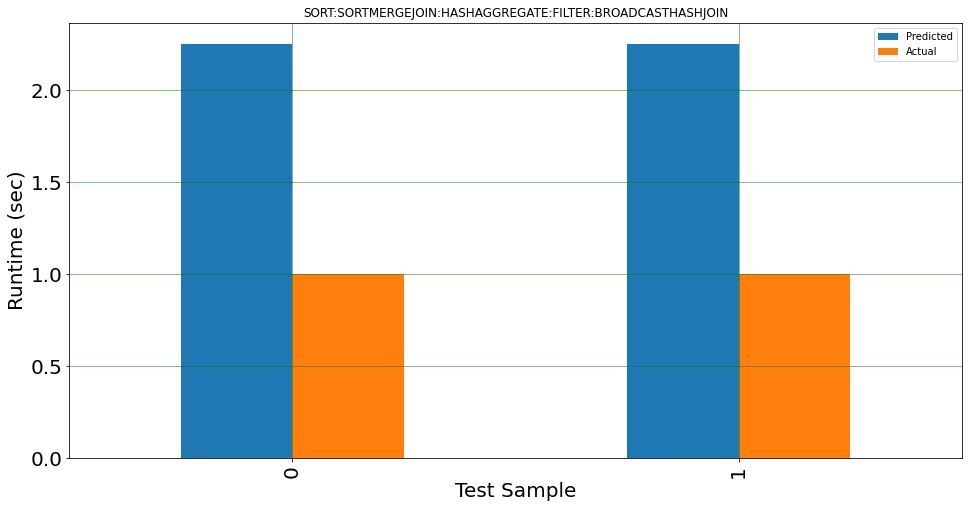

Median Absolute Error: 1.25014360116161
Max RRS Error: 1.2506995319462115
Mean Absolute Error: 1.25014360116161
Mean Squared Error: 1.562859332584356
Root Mean Squared Error: 1.2501437247710185
Mean stage runtime: 1.0
******************************************************* 



WRITE , n_training 3 n_test 1 
              Coefficient
remote_read     0.000000
cache_read      0.000000
sequential      0.001745
shuffle         0.000000
aggregate       0.000000 
intercept -117.7084587803697


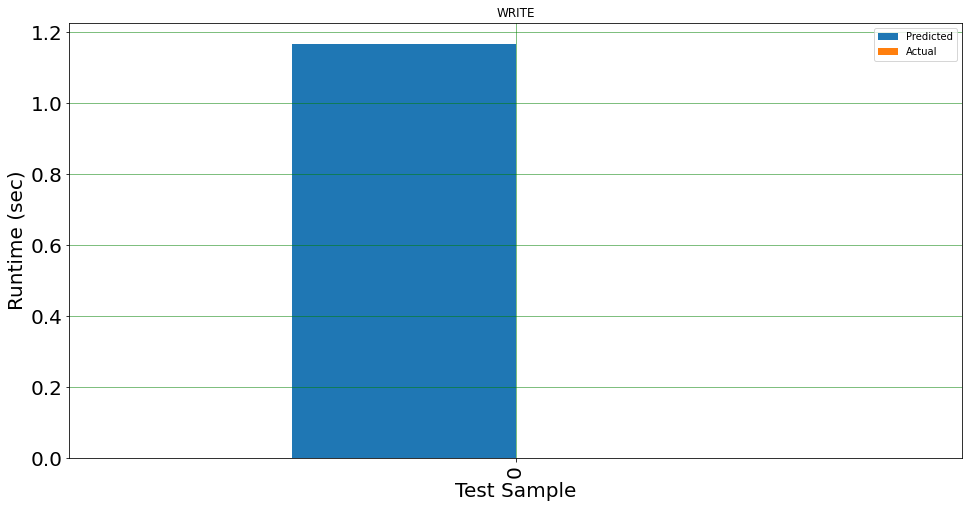

Median Absolute Error: 1.1675386118801612
Max RRS Error: 1.1675386118801612
Mean Absolute Error: 1.1675386118801612
Mean Squared Error: 1.3631464102310535
Root Mean Squared Error: 1.1675386118801612
Mean stage runtime: 0.0
******************************************************* 



skipped , n_training 3 n_test 1 
              Coefficient
remote_read     1.150851
cache_read      0.000000
sequential      0.000000
shuffle         0.000000
aggregate       0.000000 
intercept 1.273526346112645


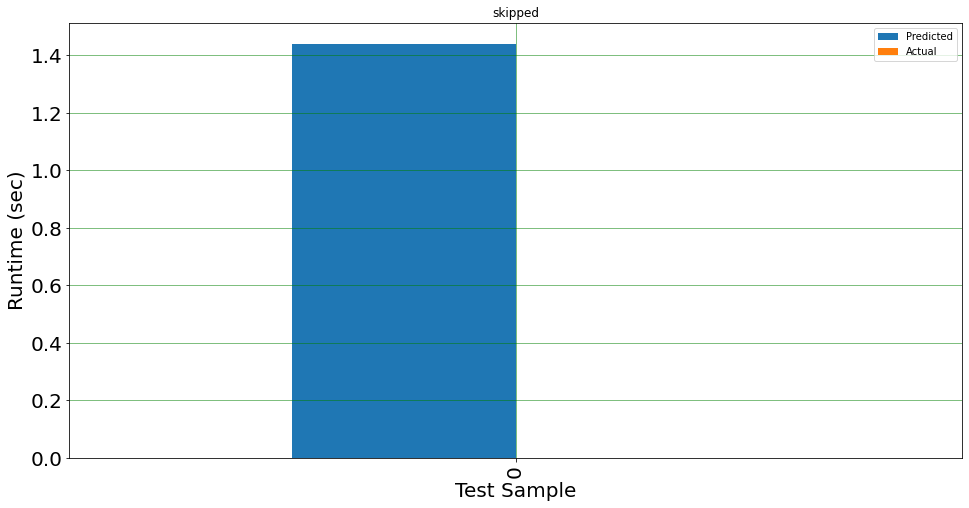

Median Absolute Error: 1.4406410137634984
Max RRS Error: 1.4406410137634984
Mean Absolute Error: 1.4406410137634984
Mean Squared Error: 2.0754465305375205
Root Mean Squared Error: 1.4406410137634984
Mean stage runtime: 0.0
******************************************************* 





In [35]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
%matplotlib inline

gdf2 = df2.groupby('feature')

regressors = {}

for index, df3 in gdf2:
    
    X = df3[['remote_read', 'cache_read', 'sequential', 'shuffle', 'aggregate']].values

    Y= df3['runtime'].values

    sc = StandardScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    
    #X_train = sc.fit_transform(X_train)
    #X_test = sc.transform(X_test)
    
    regressor = Lasso(alpha=0.0001,precompute=True,max_iter=1000,
                positive=True, random_state=9999, selection='random')
    regressor.fit(X_train,y_train)
  #  regressor = LassoCV(max_iter=1000, positive=True, random_state=9999, selection='random')
  #  regressor.fit(X,Y)
    
    #print(X_test)
    #regressor = LinearRegression()  
    #regressor.fit(X_train, y_train)

    #if index == 'SCAN':
    #    coeff_df = pd.DataFrame(regressor.coef_, 
    #                            df3[['remote_read', 'cache_read', 'sequential']].columns, 
    #                            columns=['Coefficient'])  
    #else:
    coeff_df = pd.DataFrame(regressor.coef_, 
                            df3[['remote_read', 'cache_read', 'sequential', 'shuffle', 'aggregate']].columns, 
                            columns=['Coefficient'])  
    print(index, ', n_training', len(X_train), 'n_test', len(X_test),
          '\n', coeff_df, '\nintercept', regressor.intercept_)

    y_pred = regressor.predict(X_test)

    dn = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    dn['Accuracy'] = 100*(1 - dn['Predicted']/dn['Actual'])

    df1 = dn.head(25)

    fig, ax = plt.subplots(figsize=(16, 8))
    df1[['Predicted', 'Actual']].plot(kind='bar',ax=ax)
    ax.set_title(index)
    ax.set_xlabel('Test Sample', fontsize=20)
    ax.set_ylabel('Runtime (sec)', fontsize=20)
    ax.tick_params(labelsize=20)
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.show()
    
    if index not in regressors: 
        regressors[index] = regressor; 
    
    print('Median Absolute Error:', metrics.median_absolute_error(y_test, y_pred))
    print('Max RRS Error:', metrics.max_error(y_test, y_pred))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean stage runtime:', y_test.mean())
    
    print('*******************************************************', '\n\n\n')
    


In [36]:
def predict_runtime(row):
    logd = (row['stage_input_bytes'] + row['stage_shuffle_read_bytes'])/row['numTasks']
    feature = row['feature']
    regressor = regressors[feature];
    input_sz = row['stage_input_bytes']
    cache_read =  row['prefetched_bytes']/bw_cache
    remote_read = np.abs(8*(row['stage_input_bytes'] - row['prefetched_bytes'])/(row['bw_i']*(10**9)))
    sequential = (row['stage_input_bytes'] + row['stage_shuffle_read_bytes'])/row['numTasks']
    aggregate = np.log(row['numTasks'])
    shuffle = row['numTasks']#*dt['total_bytes']
    
    #sequential = (row['stage_input_bytes'] + row['stage_shuffle_read_bytes'])/row['numTasks']
    if logd == 0:
    #    aggregate = 0
        sort = 0
    else:
    #    aggregate = np.log(logd)
        sort = (logd)*np.log(logd)

    row['predict_runtime'] = round(regressor.predict([[remote_read, cache_read, sequential, shuffle, aggregate]])[0]
                                   ,2)
    if (input_sz > 0) & (app_index in to_be_shown):
        print('stage', row['stage_id'] , 'inputs', row['tables'], 'input size', input_sz,
              'prefetched ',row['prefetched_bytes'], 'bw', row['bw_i'],
              'remote', row['stage_input_bytes'] - row['prefetched_bytes'],
              'predict', row['predict_runtime'], 'actual', row['stage_run_time'], 
              'stride', row['stride'])

    return row


n_unique = df['app_id'].nunique()
n_test = 50 #int(n_unique*0.2)
print(n_unique, n_test)
test_apps_indexes = np.random.choice(df['app_id'].unique().shape[0], n_test, replace=False) 

to_be_shown = []
total=0
cp_err = 0
cp2_err = 0
for app_index in test_apps_indexes:
    #print(app_index)
    app_id = df['app_id'].unique()[app_index]
    app = df[df['app_id']==app_id].apply(predict_runtime, axis=1)
    
    #print(app['stage_id'])
    
    query = df[df['app_id']==app_id]['name'].values[0].replace('tpch', '')
    query_dag = df[df['app_id']==app_id]['app_dag'].values[0]
    g_id = sq_df[(sq_df['query']==int(query)) & (sq_df['dag'] == query_dag)]['id'].values[0]
    g = graphs_pool[g_id].copy()
    
    predicted_runtime = g.new_edge_property("float")
    actual_runtime = g.new_edge_property("float")

    for e in g.edges():
        v = e.source()
        # print(g.vp.vids[v], g.vp.feature[v])
        if g.vp.feature[v] == 'skipped':
            actual_runtime[e] = 0
            predicted_runtime[e] = 0
        else:
            actual_runtime[e], predicted_runtime[e] = -1*(app[app['stage_id']==int(g.vp.vids[v])][[
                'stage_run_time', 'predict_runtime']].values[0])
    
    g.ep['n_predicted_runtime'] = predicted_runtime
    g.ep['n_actual_runtime'] = actual_runtime
    
    roots = [v for v in g.vertices() if ((v.in_degree() == 0) & (g.vp.feature[v] != 'skipped'))]
    leaves = [v for v in g.vertices() if v.out_degree() == 0]
    #print(roots, leaves)
    
    predict_list= []
    for root in roots:
        for leaf in leaves:
            vlist, elist = gt.shortest_path(g, g.vertex(root), g.vertex(leaf), weights=g.ep.n_predicted_runtime, 
                                            negative_weights=True, pred_map=None)
            
            dist = gt.shortest_distance(g, g.vertex(root), g.vertex(leaf), weights=g.ep.n_predicted_runtime, 
                                            negative_weights=True, pred_map=None)
            
            vlist1, elist1 = gt.shortest_path(g, g.vertex(root), g.vertex(leaf), weights=g.ep.n_actual_runtime,
                                           negative_weights=True, pred_map=None)
            dist1 = gt.shortest_distance(g, g.vertex(root), g.vertex(leaf), weights=g.ep.n_actual_runtime, 
                                            negative_weights=True, pred_map=None)
            
            
            #print('path from %d to %d: predicted lat %0.2f, actual lat %0.2f'%(root, leaf, 
            #                                                                 round(-1*dist, 2), -1*dist1))
            
            predict_list.append({'root': root, 'leaf': leaf, 'predicted':  round(-1*dist, 2), 'actual': -1*dist1,
                                'ppath': vlist, 'apath': vlist1})
     #       for v in vlist:
     #           print('predicted', v)
            
     #       for v in vlist1:
     #           print('actual', v)
    dcp = pd.DataFrame(predict_list)
    #print(dcp['predicted'].idxmax(), dcp['actual'].idxmax()) 
    if dcp['predicted'].idxmax() != dcp['actual'].idxmax():
        cp_err += 1
        print(app_index)
    else:
        pred_1s2nd_cp = dcp['predicted'].nlargest(2).index.values
        if len(pred_1s2nd_cp) > 1:
            index_2nd_pred_cp = dcp['predicted'].nlargest(2).index.values[1]
            index_2nd_actual_cp = dcp['actual'].nlargest(2).index.values[1:]
            
            #cp2_err += (index_2nd_pred_cp in index_2nd_actual_cp)
            
            if index_2nd_pred_cp not in index_2nd_actual_cp:
                print(app_id, df[df['app_id']==app_id]['app_name'].values[0])
                cp2_err += 1
                print(dcp[['root', 'leaf', 'actual', 'predicted']])
            
#        actual_2nd_cp = dcp[dcp['actual'] == dcp['actual'].nlargest(2)][['root', 'leaf']]
#        predicted_2nd_cp = dcp[dcp['predicted'] == dcp['predicted'].nlargest(2)][['root', 'leaf']]
        
        #if (actual_2nd_cp[0] == predicted_2nd_cp[0]) and (actual_2nd_cp[1] == predicted_2nd_cp[1]):
        #    print('correct 2nd cp')
        pass
    #    
    total += 1
    #print('************************************* NEXTTTTTTTTT *************************************')
    if app_index in to_be_shown:
        print(app_id, df[df['app_id']==app_id]['app_name'].values[0])
        gt.graph_draw(g, vertex_text=g.vertex_index, vertex_color=g.vp.color, 
                      vertex_fill_color=g.vp.color, size=(700, 700))
        print(dcp[['root', 'leaf', 'predicted', 'actual', 'ppath', 'apath']])
   #     break

cp_err, cp2_err, total

100 50
app-20200906120230-0222 framework:spark-name:tpch8-bw:10Gbps-ds:64G-stride:40-random:nogzgeiz
  root leaf  actual  predicted
0    0   32    16.0      17.73
1    1   32    16.0      17.73
2    2   32    16.0      20.68
3    5   32    24.0      27.62
4    6   32    13.0      21.31
5    7   32     9.0      15.22
6    8   32    19.0      29.10
7    9   32    54.0      67.43
18
1
app-20200906185653-0275 framework:spark-name:tpch5-bw:1Gbps-ds:64G-stride:25-random:dftcvtqh
  root leaf  actual  predicted
0    0   24   189.0     122.80
1    1   24   191.0     122.19
2    3   24   174.0     112.28
3    5   24   571.0     514.13
4    7   24    17.0      17.84
5    9   24    23.0      25.89
97
33
app-20200906113907-0218 framework:spark-name:tpch7-bw:10Gbps-ds:64G-stride:20-random:feuuclth
  root leaf  actual  predicted
0    0   22    21.0      17.00
1    1   22    44.0      40.05
2    2   22    52.0      68.40
3    4   22    48.0      39.20
4    5   22    17.0      11.79
56
96
21
6
23
91
ap

(10, 4, 50)

In [37]:
print(df[df['stride'] == '0']['app_id'].nunique())

n_unique = df['app_id'].nunique()
n_test = df[(df['stride'] == '0') | (df['stride'] == '10')]['app_id'].nunique() #int(n_unique*0.2)

print(n_unique, n_test)
test_apps_indexes2 = np.random.choice(df[(df['stride'] == '0') | (df['stride'] == '10')]['app_id'].unique().shape[0], n_test, replace=False)

cp_results = []

to_be_shown = []
total2=0
cp_err2 = 0
cp2_err2 = 0
for app_index in test_apps_indexes2:
    app_id = df[(df['stride'] == '0') | (df['stride'] == '10')]['app_id'].unique()[app_index]
    app = df[df['app_id']==app_id].apply(predict_runtime, axis=1)
     
    query = df[df['app_id']==app_id]['name'].values[0].replace('tpch', '')
    dataset = df[df['app_id']==app_id]['ds'].values[0];
    bw = df[df['app_id']==app_id]['bw'].values[0];
    
    
    query_dag = df[df['app_id']==app_id]['app_dag'].values[0]
    g_id = sq_df[(sq_df['query']==int(query)) & (sq_df['dag'] == query_dag)]['id'].values[0]
    g = graphs_pool[g_id].copy()
    
    predicted_runtime = g.new_edge_property("float")
    actual_runtime = g.new_edge_property("float")

    for e in g.edges():
        v = e.source()
        if g.vp.feature[v] == 'skipped':
            actual_runtime[e] = 0
            predicted_runtime[e] = 0
        else:
            actual_runtime[e], predicted_runtime[e] = -1*(app[app['stage_id']==int(g.vp.vids[v])][[
                'stage_run_time', 'predict_runtime']].values[0])
    
    g.ep['n_predicted_runtime'] = predicted_runtime
    g.ep['n_actual_runtime'] = actual_runtime
    
    roots = [v for v in g.vertices() if ((v.in_degree() == 0) & (g.vp.feature[v] != 'skipped'))]
    leaves = [v for v in g.vertices() if v.out_degree() == 0]
    
    predict_list= []
    for root in roots:
        for leaf in leaves:
            vlist, elist = gt.shortest_path(g, g.vertex(root), g.vertex(leaf), weights=g.ep.n_predicted_runtime, 
                                            negative_weights=True, pred_map=None)
            
            dist = gt.shortest_distance(g, g.vertex(root), g.vertex(leaf), weights=g.ep.n_predicted_runtime, 
                                            negative_weights=True, pred_map=None)
            
            vlist1, elist1 = gt.shortest_path(g, g.vertex(root), g.vertex(leaf), weights=g.ep.n_actual_runtime,
                                           negative_weights=True, pred_map=None)
            dist1 = gt.shortest_distance(g, g.vertex(root), g.vertex(leaf), weights=g.ep.n_actual_runtime, 
                                            negative_weights=True, pred_map=None)
            
            predict_list.append({'root': root, 'leaf': leaf, 'predicted':  round(-1*dist, 2), 'actual': -1*dist1,
                                'ppath': vlist, 'apath': vlist1})
            
    
    cps_df = pd.DataFrame(predict_list)
    if cps_df['predicted'].idxmax() != cps_df['actual'].idxmax():
        cp_err2 += 1
        print(int(query), bw, dataset, cps_df['predicted'].max(), cps_df['actual'].max())
        print(cps_df[['actual', 'predicted']].sort_values('actual'))
        #to_be_shown.append(app_index)
    else:
        cp_results.append({'query': int(query), 'dataset': dataset, 
                           'bandwidth': bw, 'predicted': cps_df['predicted'].max(),
                          'actual': cps_df['actual'].max()})
        pred_1s2nd_cp = cps_df['predicted'].nlargest(2).index.values
        if len(pred_1s2nd_cp) > 1:
            index_2nd_pred_cp = cps_df['predicted'].nlargest(2).index.values[1]
            index_2nd_actual_cp = cps_df['actual'].nlargest(2).index.values[1:]
            
            if index_2nd_pred_cp not in index_2nd_actual_cp:
                cp2_err2 += 1
                print('second', int(query), bw, dataset)
                print(cps_df[['actual', 'predicted']].sort_values('actual'))
                
    total2 += 1
    if app_index in to_be_shown:
        print(app_id, df[df['app_id']==app_id]['app_name'].values[0])
        gt.graph_draw(g, vertex_text=g.vertex_index, vertex_color=g.vp.color, 
                      vertex_fill_color=g.vp.color, size=(700, 700))
        print(dcp[['root', 'leaf', 'predicted', 'actual', 'ppath', 'apath']])

print(cp_err2, cp2_err2, total2)

cp_df = pd.DataFrame(cp_results)
cp_df['accuracy'] = (cp_df['actual']/cp_df['predicted'])
cp_df = cp_df.round({'accuracy': 2}).sort_values(by='query').reset_index(drop=True)

cp_df[['query', 'dataset', 'bandwidth', 'actual', 'predicted', 'accuracy']].sort_values('actual')

0
100 0
0 0 0


KeyError: 'actual'

ValueError: Could not interpret input 'accuracy'

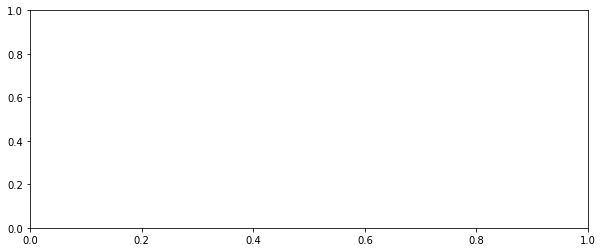

In [24]:
from mpl_toolkits.axisartist.axislines import SubplotZero
import matplotlib.ticker as ticker
import seaborn as sns

def format_xticks(x, pos=None):
    return 'Q%s'%(cp_df.iloc[x]['query'])


fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x=cp_df.index, y="accuracy", ax = ax, data=cp_df, color='#a6d96a')
ax.axhline(1, color='#4d4d4d')
ax.set_ylabel('actual/predicted', fontsize=20)
ax.set_xlabel('Queries', fontsize=20)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks))
ax.tick_params(labelsize=16)

fig, ax = plt.subplots(figsize=(10, 4))
cp_df[['predicted', 'actual']].plot.bar(ax = ax)
ax.axhline(1, color='#4d4d4d')
ax.set_ylabel('actual/predicted', fontsize=20)
ax.set_xlabel('Queries', fontsize=20)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks))
ax.tick_params(labelsize=16)


In [25]:
from mpl_toolkits.axisartist.axislines import SubplotZero
import matplotlib.ticker as ticker
import seaborn as sns

def format_xticks(x, pos=None):
    return 'Q%s'%(final_cp_df.iloc[x]['query'])


def max_accuracy(grp):
    return np.abs(grp['accuracy'] - 1).idxmin()

gps = cp_df.groupby('query').apply(max_accuracy).values
final_cp_df = cp_df.iloc[gps , :]

final_cp_df.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=final_cp_df.index, y="accuracy", ax = ax, data=final_cp_df, color='#a6d96a')

for index, p in enumerate(ax.patches):
    ax.annotate('%s, %s: %ds'%(final_cp_df.iloc[index, :]['bandwidth'], 
                               final_cp_df.iloc[index, :]['dataset'],
                               final_cp_df.iloc[index, :]['actual']),
                   (p.get_x() + p.get_width() / 2., 0.4), 
                   ha = 'center', va = 'center', fontsize=16,
                   xytext = (0, 9), 
                   textcoords = 'offset points', rotation=90)

ax.annotate("",
            xy=(0.2, 0.2), xycoords='data',
            xytext=(0.8, 0.8), textcoords='data',
            color = 'black',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )



ax.axhline(1, color='#4d4d4d')
ax.set_ylabel('longest path\n actual/predicted\n', fontsize=20)
ax.set_xlabel('Queries', fontsize=20)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks))
ax.tick_params(labelsize=16)
plt.xticks(rotation=45)

plt.tight_layout()
fig.savefig('/local0/Kariz/code/ipython/fig_runtime_prediction.pdf', format='pdf', dpi=200)
fig.savefig('/local0/Kariz/code/ipython/fig_runtime_prediction.png', format='png', dpi=200)
plt.show()


fig, ax = plt.subplots(figsize=(10, 4))
final_cp_df[['predicted', 'actual']].plot.bar(ax = ax)
ax.axhline(1, color='#4d4d4d')
ax.set_ylabel('actual/predicted\n longest path', fontsize=20)
ax.set_xlabel('Queries', fontsize=20)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks))
ax.tick_params(labelsize=16)


final_cp_df


KeyError: 'query'

In [1271]:
print(df2.columns)
gps = df.groupby(['feature', 'bw', 'ds', 'prefetched_blocks'])
gps.ngroups, len(df)

Index(['prefetched_bytes', 'feature', 'input_sz', 'cache_read', 'remote_read',
       'sequential', 'aggregate', 'sort', 'shuffle', 'runtime', 'app_name',
       'stage_id', 'tables'],
      dtype='object')


(559, 2133)

In [1318]:
for index, group in gps:
    #print(group['app_name'])
    if index != ('SCAN', '10Gbps', '32G', 0):
        continue
    print(index, len(group))
    #print(group.columns)
    
    dfg = pd.DataFrame()
    dfg['prefetched_bytes'] = group['prefetched_bytes']
    dfg['feature'] = group['feature']
    dfg['input_sz'] = group['stage_input_bytes']
    dfg['cache_read'] =  group['prefetched_bytes']/bw_cache
    dfg['remote_read'] = np.abs(8*(group['stage_input_bytes'] - group['prefetched_bytes'])/(group['bw_i']*(10**9)))
    dfg['sequential'] = (group['stage_input_bytes'] + group['stage_shuffle_read_bytes'])/group['numTasks']
    dfg['aggregate'] = np.log(group['numTasks'])#df.apply(get_aggregate, axis=1) #np.log((df['stage_input_bytes'] + df['stage_shuffle_read_bytes'])/df['numTasks'])
    dfg['sort'] = group.apply(get_sort, axis=1) #((df['stage_input_bytes'] + df['stage_shuffle_read_bytes'])/df['numTasks'])*np.log((df['stage_input_bytes'] + df['stage_shuffle_read_bytes'])/df['numTasks'])
    dfg['shuffle'] = (group['numTasks'])#*dt['total_bytes']
    dfg['runtime'] = group['stage_run_time']
    dfg['app_name'] = group['app_name']
    dfg['stage_id'] = group['stage_id']
    dfg['tables'] = group['tables']
    
    X = dfg[['remote_read', 'cache_read', 'sequential', 'shuffle', 'aggregate']].values
    Y= dfg['runtime'].values

    y_pred = regressor.predict(X)
    
    sum_errors = 0
    for ys in zip(Y, y_pred):
        sum_errors += (ys[0] - ys[1])**2
    
    print(np.sqrt(sum_errors/(len(Y) - 1)), np.sqrt(sum_errors/(len(Y))), np.max(Y), np.mean(Y), np.min(Y))
    
    
    break

('SCAN', '10Gbps', '32G', 0) 10
4.287820154891264 4.067783365989709 7.0 4.4 1.0


In [1351]:
print(df.columns)

Index(['app_completion_time', 'app_dag', 'app_id', 'app_name',
       'app_start_time', 'bw', 'ds', 'framework', 'job_completion_time',
       'job_id', 'job_stage_ids', 'job_submission_time', 'name', 'numTasks',
       'outputBytes', 'random', 'stage_completion_time', 'stage_id',
       'stage_input_bytes', 'stage_queue_time', 'stage_rdds', 'stage_run_time',
       'stage_shuffle_read_bytes', 'stage_shuffle_write_bytes',
       'stage_start_time', 'stage_submission_time', 'stride', 'app_runtime',
       'feature', 'tables', 'prefetched_blocks', 'prefetched_bytes', 'bw_i',
       'sequentials'],
      dtype='object')


In [1370]:
import random

queries = df.groupby('app_id')['app_id'].agg('max').values

queries = random.sample(list(queries), 100)
queries

['app-20200905114946-0016',
 'app-20200905163914-0108',
 'app-20200906170431-0243',
 'app-20200905155937-0096',
 'app-20200905123417-0034',
 'app-20200906094005-0193',
 'app-20200906192020-0278',
 'app-20200905184332-0144',
 'app-20200905132024-0046',
 'app-20200906095710-0198',
 'app-20200906164057-0234',
 'app-20200906120725-0223',
 'app-20200905131041-0044',
 'app-20200906171302-0247',
 'app-20200906090303-0182',
 'app-20200906192726-0279',
 'app-20200906083141-0172',
 'app-20200906183905-0270',
 'app-20200905183443-0142',
 'app-20200906205822-0296',
 'app-20200906082909-0171',
 'app-20200905172800-0124',
 'app-20200906172522-0251',
 'app-20200905191246-0148',
 'app-20200905175622-0131',
 'app-20200905190424-0147',
 'app-20200906084904-0178',
 'app-20200905172313-0123',
 'app-20200905164219-0109',
 'app-20200905182030-0138',
 'app-20200905170611-0118',
 'app-20200905160240-0097',
 'app-20200905171848-0121',
 'app-20200905171046-0119',
 'app-20200906193403-0280',
 'app-20200905165053

In [1373]:
df[df['app_id'].isin(queries)].to_csv('/local0/Kariz/expriments/simulator/multidag/config/spark_multidag_selected_queries.csv', header=True, index=False)

In [1371]:
df[df['app_id'].isin(queries)]

,app_completion_time,app_dag,app_id,app_name,app_start_time,bw,ds,framework,job_completion_time,job_id,...,stage_start_time,stage_submission_time,stride,app_runtime,feature,tables,prefetched_blocks,prefetched_bytes,bw_i,sequentials
28,1599317360134,"j:0,e:->0\nj:0,e:->1\nj:0,e:0->2\nj:0,e:1->2\nj:0,e:2->3\nj:0,e:3->4\nj:1,e:8->9\nj:1,e:->5\nj:1,e:->6\nj:1,e:9->10\nj:1,e:5->7\nj:1,e:6->7\nj:1,e:7->8\n",app-20200905104849-0012,framework:spark-name:tpch13-bw:40Gbps-ds:20G-stride:80-random:ufhowguh,1599317328943,40Gbps,20G,spark,1.599332e+09,1,...,1.599332e+09,1.599332e+09,80,31191,HASHAGGREGATE,,0,0,40.0,2.218380e+03
29,1599317360134,"j:0,e:->0\nj:0,e:->1\nj:0,e:0->2\nj:0,e:1->2\nj:0,e:2->3\nj:0,e:3->4\nj:1,e:8->9\nj:1,e:->5\nj:1,e:->6\nj:1,e:9->10\nj:1,e:5->7\nj:1,e:6->7\nj:1,e:7->8\n",app-20200905104849-0012,framework:spark-name:tpch13-bw:40Gbps-ds:20G-stride:80-random:ufhowguh,1599317328943,40Gbps,20G,spark,1.599332e+09,1,...,1.599332e+09,1.599332e+09,80,31191,SORT,,0,0,40.0,6.282000e+01
30,1599317360134,"j:0,e:->0\nj:0,e:->1\nj:0,e:0->2\nj:0,e:1->2\nj:0,e:2->3\nj:0,e:3->4\nj:1,e:8->9\nj:1,e:->5\nj:1,e:->6\nj:1,e:9->10\nj:1,e:5->7\nj:1,e:6->7\nj:1,e:7->8\n",app-20200905104849-0012,framework:spark-name:tpch13-bw:40Gbps-ds:20G-stride:80-random:ufhowguh,1599317328943,40Gbps,20G,spark,1.599332e+09,0,...,1.599332e+09,1.599332e+09,80,31191,SCAN:FILTER,orders,665,2789212160,40.0,8.718721e+07
31,1599317360134,"j:0,e:->0\nj:0,e:->1\nj:0,e:0->2\nj:0,e:1->2\nj:0,e:2->3\nj:0,e:3->4\nj:1,e:8->9\nj:1,e:->5\nj:1,e:->6\nj:1,e:9->10\nj:1,e:5->7\nj:1,e:6->7\nj:1,e:7->8\n",app-20200905104849-0012,framework:spark-name:tpch13-bw:40Gbps-ds:20G-stride:80-random:ufhowguh,1599317328943,40Gbps,20G,spark,1.599332e+09,0,...,1.599332e+09,1.599332e+09,80,31191,SCAN,customer,80,335544320,40.0,1.219517e+07
32,1599317360134,"j:0,e:->0\nj:0,e:->1\nj:0,e:0->2\nj:0,e:1->2\nj:0,e:2->3\nj:0,e:3->4\nj:1,e:8->9\nj:1,e:->5\nj:1,e:->6\nj:1,e:9->10\nj:1,e:5->7\nj:1,e:6->7\nj:1,e:7->8\n",app-20200905104849-0012,framework:spark-name:tpch13-bw:40Gbps-ds:20G-stride:80-random:ufhowguh,1599317328943,40Gbps,20G,spark,1.599332e+09,0,...,1.599332e+09,1.599332e+09,80,31191,SORT:SORTMERGEJOIN:HASHAGGREGATE,,0,0,40.0,1.637837e+06
33,1599317360134,"j:0,e:->0\nj:0,e:->1\nj:0,e:0->2\nj:0,e:1->2\nj:0,e:2->3\nj:0,e:3->4\nj:1,e:8->9\nj:1,e:->5\nj:1,e:->6\nj:1,e:9->10\nj:1,e:5->7\nj:1,e:6->7\nj:1,e:7->8\n",app-20200905104849-0012,framework:spark-name:tpch13-bw:40Gbps-ds:20G-stride:80-random:ufhowguh,1599317328943,40Gbps,20G,spark,1.599332e+09,0,...,1.599332e+09,1.599332e+09,80,31191,HASHAGGREGATE,,0,0,40.0,8.940749e+04
34,1599317360134,"j:0,e:->0\nj:0,e:->1\nj:0,e:0->2\nj:0,e:1->2\nj:0,e:2->3\nj:0,e:3->4\nj:1,e:8->9\nj:1,e:->5\nj:1,e:->6\nj:1,e:9->10\nj:1,e:5->7\nj:1,e:6->7\nj:1,e:7->8\n",app-20200905104849-0012,framework:spark-name:tpch13-bw:40Gbps-ds:20G-stride:80-random:ufhowguh,1599317328943,40Gbps,20G,spark,1.599332e+09,0,...,1.599332e+09,1.599332e+09,80,31191,HASHAGGREGATE,,0,0,40.0,2.218380e+03
35,1599317508530,"j:0,e:->0\nj:0,e:->1\nj:0,e:4->5\nj:0,e:0->2\nj:0,e:1->2\nj:0,e:->3\nj:0,e:2->4\nj:0,e:3->4\nj:1,e:6->9\nj:1,e:7->9\nj:1,e:->6\nj:1,e:9->10\nj:1,e:8->10\nj:1,e:->7\nj:1,e:10->11\nj:1,e:->8\nj:2,e:12->15\nj:2,e:13->15\nj:2,e:->12\nj:2,e:15->16\nj:2,e:14->16\nj:2,e:->13\nj:2,e:16->17\nj:2,e:17->18\nj:2,e:->14\n",app-20200905105112-0013,framework:spark-name:tpch11-bw:5Gbps-ds:20G-stride:60-random:phbqgajg,1599317471932,5Gbps,20G,spark,1.599332e+09,2,...,1.599332e+09,1.599332e+09,60,36598,HASHAGGREGATE,,0,0,5.0,6.070622e+04
36,1599317508530,"j:0,e:->0\nj:0,e:->1\nj:0,e:4->5\nj:0,e:0->2\nj:0,e:1->2\nj:0,e:->3\nj:0,e:2->4\nj:0,e:3->4\nj:1,e:6->9\nj:1,e:7->9\nj:1,e:->6\nj:1,e:9->10\nj:1,e:8->10\nj:1,e:->7\nj:1,e:10->11\nj:1,e:->8\nj:2,e:12->15\nj:2,e:13->15\nj:2,e:->12\nj:2,e:15->16\nj:2,e:14->16\nj:2,e:->13\nj:2,e:16->17\nj:2,e:17->18\nj:2,e:->14\n",app-20200905105112-0013,framework:spark-name:tpch11-bw:5Gbps-ds:20G-stride:60-random:phbqgajg,1599317471932,5Gbps,20G,spark,1.59933